# IMPORTING AND CONFIGURATION

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# USO BÁSICO
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std

#PREPROCESAMIENTO
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

#DIVIDIR MODELO
from sklearn.model_selection import train_test_split

#MODELOS
from sklearn.linear_model import LassoCV,RidgeCV,LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb

#Análisis
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

#exportModel
import pickle


# GENERATE DATASET

## Declaring Functions

In [ ]:
def encoding_categorical_feats (df):
  color_categorization = {'J':1,'I':2,'H':3,'G':4,
                          'F':5,'E':6,'D':7}

  clarity_categorization = {'I1':1,'SI2':2,'SI1':3,'VS2':4,
                            'VS1':5,'VVS2':6,'VVS1':7,'IF':8}

  cut_categorization = {'Fair':1,'Good':2,'Very Good':3,
                        'Premium':4,'Ideal':5}

  df['color']=df['color'].map(color_categorization)
  df['clarity']=df['clarity'].map(clarity_categorization)
  df['cut']=df['cut'].map(cut_categorization)

  return df


def errase_outliers (df):
  #diamonds.describe(percentiles=[0.999])
  #borrar valores por encima del percentil 99.9%

  df = df[df['carat']<2.68]
  df = df[df['depth']<68.800]
  df = df[df['table']<67]
  df = df[df['x']<8.9]
  df = df[df['y']<8.885460]
  df = df[df['z']<5.54]

  return df

## CREATING AND CLEANING DATASET

In [ ]:
diamonds = pd.read_csv('/content/drive/My Drive/00_IRONHACK/diamonds_comp/data/diamonds_train.csv');

In [ ]:
print(f'Initial df: {diamonds.shape}')
initial_rows = diamonds.shape[0]
display(diamonds.head())
diamonds = errase_outliers(diamonds)
diamonds = encoding_categorical_feats (diamonds)
print(f'\n\nPost cleaning df: {diamonds.shape}')
display(diamonds.head())
print(f'{initial_rows - diamonds.shape[0]} outliers deleted')

Initial df: (40455, 10)


,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.21,Premium,J,VS2,62.4,58.0,4268,6.83,6.79,4.25
1,0.32,Very Good,H,VS2,63.0,57.0,505,4.35,4.38,2.75
2,0.71,Fair,G,VS1,65.5,55.0,2686,5.62,5.53,3.65
3,0.41,Good,D,SI1,63.8,56.0,738,4.68,4.72,3.00
4,1.02,Ideal,G,SI1,60.5,59.0,4882,6.55,6.51,3.95




Post cleaning df: (40291, 10)


,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.21,4,1,4,62.4,58.0,4268,6.83,6.79,4.25
1,0.32,3,3,4,63.0,57.0,505,4.35,4.38,2.75
2,0.71,1,4,5,65.5,55.0,2686,5.62,5.53,3.65
3,0.41,2,7,3,63.8,56.0,738,4.68,4.72,3.00
4,1.02,5,4,3,60.5,59.0,4882,6.55,6.51,3.95


164 outliers deleted


In [ ]:
working_features = ['carat','cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']
target = 'price'

In [ ]:
diamonds_train, diamonds_test = train_test_split(diamonds,test_size=0.2)
diamonds_train, diamonds_eval = train_test_split(diamonds_train,test_size=0.1)
print(f'TRAIN{diamonds_train.shape}')
print(f'TEST: {diamonds_test.shape}')
print(f'EVAL: {diamonds_eval.shape}')

TRAIN(29008, 10)
TEST: (8059, 10)
EVAL: (3224, 10)


## PREPROCESOR

In [ ]:
class CustomNumericalTransformer (BaseEstimator,TransformerMixin):
  def _init_(self):
      pass
  
  def fit (self, X, y = None):
      return self
  
  def transform (self, X, y = None):

      #dimension
      X.loc[:,'dimensions'] = X['x'] * X['y'] * X['z']
      #drop redundant columns
      X.drop(['x','y','z'],axis = 1)

      #carat_size
      X.loc[:,'carat_size'] =  X['carat']/X['dimensions']
      X.drop('dimensions',axis=1) #revisar si es mejor dejarlo
        
      #Converting any infinity values in the dataset to Nan
      X = X.replace ([np.inf,-np.inf],np.nan)
      
      return X.values



numeric_feats_pipeline = Pipeline(steps=[('custom_changes',CustomNumericalTransformer()),
                                         ('imputer',SimpleImputer(strategy='median')),
                                         ('standar_scaler',StandardScaler())])

preprocesor = ColumnTransformer(transformers=[('numeric_pipeline',numeric_feats_pipeline,working_features)])

# MODEL DEFINITION

In [ ]:

#XGBOOST_______________________________________________________________________
xgbboost_pipeline = make_pipeline(preprocesor,
                                  xgb.XGBRegressor())
    # n_estimators=1024

#Gradient Boost Regressor______________________________________________________
gradient_pipeline = make_pipeline(preprocesor,
                    GradientBoostingRegressor())

#RandomForest__________________________________________________________________

randomforest_pipeline = make_pipeline(preprocesor,
                            RandomForestRegressor())

#Lightgbm______________________________________________________________________

lightbm_pipeline = make_pipeline(preprocesor,
                            lgb.LGBMRegressor())



'''
#svr
svr_pipeline = make_pipeline(preprocesor,
                             SVR())
'''

'''
#KNeighborsRegressor
KNeighborsRegressor_pipeline = make_pipeline(preprocesor,
                                             KNeighborsRegressor())
'''

'''
#lasso
lasso_pipeline = make_pipeline(preprocesor,
                               LassoCV())
'''
;

''

In [ ]:
# get a list of models to evaluate
def get_models():
	models = dict()
	models['xgboost'] = xgbboost_pipeline
	models['gradientboost'] = gradient_pipeline
	models['random_forest'] = randomforest_pipeline
	models['lightgbm'] = lightbm_pipeline

	models['stacking'] = get_stacking()
	
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', 
	                         cv=cv, n_jobs=-1, error_score='raise')
	return scores

def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('xgboost', xgbboost_pipeline))
	level0.append(('gradientboost', gradient_pipeline))
	level0.append(('random_forest', randomforest_pipeline))
	level0.append(('lightgbm', lightbm_pipeline))
 
  # define meta learner model
	level1 = LinearRegression() #cambiar por RidgeCV()

	# define the stacking ensemble
	model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
	return model



# MODELS COMBINED TEST

In [ ]:
# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()

for name, model in models.items():
  scores = evaluate_model(model, diamonds[working_features], diamonds[target])
  results.append(scores)
  names.append(name)
  print(f'{name}: {-np.mean(scores)}')


xgboost: 534.2868333112846
gradientboost: 536.0819186560931


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


random_forest: 538.3710807710152
lightgbm: 526.6707196674872
stacking: 508.63764985582037


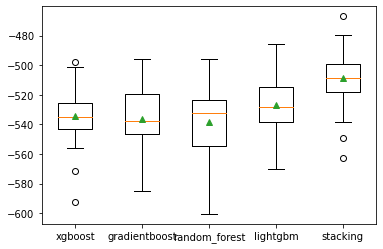

In [ ]:
# plot model performance for comparison
from matplotlib import pyplot
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

# STACKED MODEL TEST

In [ ]:
base_models = [('xgboost', xgbboost_pipeline),
               ('gradientboost', gradient_pipeline),
               ('random_forest', randomforest_pipeline),
               ('lightgbm', lightbm_pipeline)]

upper_model = LinearRegression()     

ml_model = StackingRegressor(estimators=base_models, final_estimator=upper_model, cv=5)

In [ ]:
#ENTRENAMIENTO DEL MODELO
ml_model.fit(diamonds_train[working_features],diamonds_train[target])

[12:09:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:09:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:09:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:09:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:09:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:09:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


StackingRegressor(cv=5,
                  estimators=[('xgboost',
                               Pipeline(memory=None,
                                        steps=[('columntransformer',
                                                ColumnTransformer(n_jobs=None,
                                                                  remainder='drop',
                                                                  sparse_threshold=0.3,
                                                                  transformer_weights=None,
                                                                  transformers=[('numeric_pipeline',
                                                                                 Pipeline(memory=None,
                                                                                          steps=[('custom_changes',
                                                                                                  CustomNumericalTransformer()),
                    

In [ ]:
#Error en train
y_train_pred = ml_model.predict(diamonds_train[working_features])
y_train_real = diamonds_train[target]
mean_squared_error(y_pred=y_train_pred,y_true=y_train_real,squared=False)

359.64618962779343

In [ ]:
#Error en test
y_test_pred = ml_model.predict(diamonds_test[working_features])
y_test_real = diamonds_test[target]
mean_squared_error(y_pred=y_test_pred,y_true=y_test_real,squared=False)

522.3511042051533

# TRAINING FINAL MODEL

In [ ]:
ml_model.fit(diamonds[working_features],diamonds[target])

[11:56:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:57:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:57:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:57:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:57:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:57:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


StackingRegressor(cv=5,
                  estimators=[('xgboost',
                               Pipeline(memory=None,
                                        steps=[('columntransformer',
                                                ColumnTransformer(n_jobs=None,
                                                                  remainder='drop',
                                                                  sparse_threshold=0.3,
                                                                  transformer_weights=None,
                                                                  transformers=[('numeric_pipeline',
                                                                                 Pipeline(memory=None,
                                                                                          steps=[('custom_changes',
                                                                                                  CustomNumericalTransformer()),
                    

# SAVING TRAINED MODEL

In [ ]:
filename = 'stacking_model_v2_plain.sav'
pickle.dump(ml_model, open(filename, 'wb'))

#SUBMITTING

In [ ]:
diamonds_submit = pd.read_csv('/content/drive/My Drive/00_IRONHACK/diamonds_comp/data/diamonds_predict.csv')

In [ ]:
diamonds_submit = encoding_categorical_feats(diamonds_submit)

In [ ]:
results = ml_model.predict(diamonds_submit[working_features])
submission_df = pd.DataFrame({'id': diamonds_submit['id'], 'price': results})


In [ ]:
submission_df.describe()

,id,price
count,13485.000000,13485.000000
mean,6742.000000,3945.402305
std,3892.928525,3948.917158
min,0.000000,369.840162
25%,3371.000000,925.017746
50%,6742.000000,2463.677268
75%,10113.000000,5310.064460
max,13484.000000,17961.720181


In [ ]:
submission_df.describe()

,id,price
count,13485.000000,13485.000000
mean,6742.000000,3948.559661
std,3892.928525,3953.775776
min,0.000000,276.509833
25%,3371.000000,942.953655
50%,6742.000000,2446.898229
75%,10113.000000,5327.123715
max,13484.000000,18827.989485


In [ ]:
submission_df.to_csv('pipeline_model_v2.csv', index=False)